In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
from sklearn import svm
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
from models import networks
from torch import nn
from configs.base import Config
import matplotlib.pyplot as plt
import numpy as np
import glob
from models.networks import _4M_SER
from pytorch_grad_cam.utils.image import show_cam_on_image
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

In [2]:
checkpoint_path = "checkpoints_latest/IEMOCAP/_4M_SER_bert_vggish/20240324-231013"
cfg_path = os.path.join(checkpoint_path, "cfg.log")
all_state_dict = True
ckpt_path = os.path.join(
    checkpoint_path, "weights/best_acc/checkpoint_0_0.pt"
)
if not os.path.exists(ckpt_path):
    ckpt_path = os.path.join(
        checkpoint_path, "weights/best_acc/checkpoint_0.pth"
    )
    all_state_dict = False

cfg = Config()
cfg.load(cfg_path)
cfg.audio_postprocess = True

In [3]:
class _4M_SER_Grad(_4M_SER):
    def init_inner_layer(self):
        self.vggish_features_conv = self.audio_encoder.vggish.features[:15]
        self.vggish_max_pool = self.audio_encoder.vggish.features[15]
        self.vggish_embeddings = self.audio_encoder.vggish.embeddings
        self.gradients=None
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, input_audio):
        out = []
        for i in range(input_audio.size(0)):
            x = self.vggish_features_conv(input_audio[i])
            out.append(x)
        return torch.stack(out, dim=0)
    
    def forward(
        self,
        input_text: torch.Tensor,
        input_audio: torch.Tensor,
        output_attentions: bool = False,
    ):

        text_embeddings = input_text
        audio_embeddings = input_audio
        if not self.transfer_learning:
            text_output = self.text_encoder(input_text)
            text_embeddings = text_output.last_hidden_state
            if output_attentions:
                text_embeddings_attentions = text_output.attentions
            # audio_embeddings = self.audio_encoder(input_audio)
            # start audio_embeddings
            
            
            out = []
            for i in range(input_audio.size(0)):
                x = self.vggish_features_conv(input_audio[i])
                
                h = x.register_hook(self.activations_hook)
                
                x = self.vggish_max_pool(x)
                # Transpose the output from features to
                # remain compatible with vggish embeddings
                x = torch.transpose(x, 1, 3)
                x = torch.transpose(x, 1, 2)
                x = x.contiguous()
                x = x.view(x.size(0), -1)
                x = self.vggish_embeddings(x)
                out.append(x)

            
            audio_embeddings = torch.stack(out, dim=0)
            if len(audio_embeddings.size()) == 2:
                audio_embeddings = audio_embeddings.unsqueeze(1)
            # end audio_embeddings

        if self.audio_norm_type == "layer_norm":
            audio_embeddings_norm = self.audio_encoder_layer_norm(audio_embeddings)
        elif self.audio_norm_type == "min_max":
            # Min-max normalization
            audio_embeddings_norm = (audio_embeddings - audio_embeddings.min()) / (
                audio_embeddings.max() - audio_embeddings.min()
            )
        else:
            audio_embeddings_norm = audio_embeddings

        ## Fusion Module
        # Self-attention to reduce the dimensionality of the text embeddings
        text_attention, text_attn_output_weights = self.text_attention(
            text_embeddings,
            text_embeddings,
            text_embeddings,
            average_attn_weights=False,
        )
        text_linear = self.text_linear(text_attention)
        text_norm = self.text_layer_norm(text_linear)

        # Concatenate the text and audio embeddings
        fusion_embeddings = torch.cat((text_norm, audio_embeddings_norm), 1)

        # Selt-attention module
        fusion_attention, fusion_attn_output_weights = self.fusion_attention(
            fusion_embeddings,
            fusion_embeddings,
            fusion_embeddings,
            average_attn_weights=False,
        )
        fusion_linear = self.fusion_linear(fusion_attention)
        fusion_norm = self.fusion_layer_norm(fusion_linear)

        # Get classification output
        if self.fusion_head_output_type == "cls":
            cls_token_final_fusion_norm = fusion_norm[:, 0, :]
        elif self.fusion_head_output_type == "mean":
            cls_token_final_fusion_norm = fusion_norm.mean(dim=1)
        elif self.fusion_head_output_type == "max":
            cls_token_final_fusion_norm = fusion_norm.max(dim=1)
        else:
            raise ValueError("Invalid fusion head output type")

        # Classification head
        x = cls_token_final_fusion_norm
        x = self.dropout(x)
        for i, _ in enumerate(self.linear_layer_output):
            x = getattr(self, f"linear_{i}")(x)
            x = nn.functional.leaky_relu(x)
        out = self.classifer(x)

        if output_attentions:
            return [out, cls_token_final_fusion_norm], [
                text_embeddings_attentions,
                text_attn_output_weights,
                fusion_attn_output_weights,
            ]

        return out, cls_token_final_fusion_norm, text_norm, audio_embeddings_norm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = _4M_SER_Grad(cfg)
network.to(device)

# Build dataset
train_ds, val_ds = build_train_test_dataset(cfg)
cfg.data_valid = "test.pkl"
_, test_ds = build_train_test_dataset(cfg)

weight = torch.load(ckpt_path, map_location=torch.device(device))
if all_state_dict:
    weight = weight["state_dict_network"]

network.load_state_dict(weight)
network.init_inner_layer()
network.eval()
network = network.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
data_path = glob.glob("heatmaps/*.wav")

In [6]:
audio_path = data_path[0]
print(audio_path)
audio_name = os.path.basename(audio_path)[:-4]
input_ids = torch.load(f'heatmaps/{audio_name}_input_ids.pt')
audio = torch.load(f'heatmaps/{audio_name}_audio.pt')
label = torch.load(f'heatmaps/{audio_name}_label.pt')

heatmaps/Ses02F_script01_2_M008.wav


In [7]:
import cv2
emo = -1
while True:
    # input_ids, audio, label = next(iter(train_ds))
    network.eval()
    output = network(input_ids.to(device),audio.to(device))[0]
    if (output.argmax().item() == label.item()):
        emo = output.argmax().item()
        output[0, emo].backward()
        
        # pull the gradients out of the model
        gradients = network.get_activations_gradient()
        
        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        # get the activations of the last convolutional layer
        activations = network.get_activations(audio.to('cpu')).detach()[0]
        # weight the channels by corresponding gradients
        for i in range(512):
            activations[:, i, :, :] *= pooled_gradients[i]
        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        heatmap = np.maximum(heatmap.numpy(), 0)
        # # normalize the heatmap
        audio_mel = []
        audio_grad_cam = []
        for index in range(heatmap.shape[0]):
            h = heatmap[index]/np.max(heatmap[index]) if np.max(heatmap[index]) != 0 else heatmap[index]
            audio_mel.append(audio[0][index])
            audio_grad_cam.append(h)
        break

In [8]:
import soundfile as sf
import sounddevice as sd
import os
wav_data, sr = sf.read(audio_path, dtype="int16")
sd.play(wav_data, sr)
num_samples = len(wav_data)

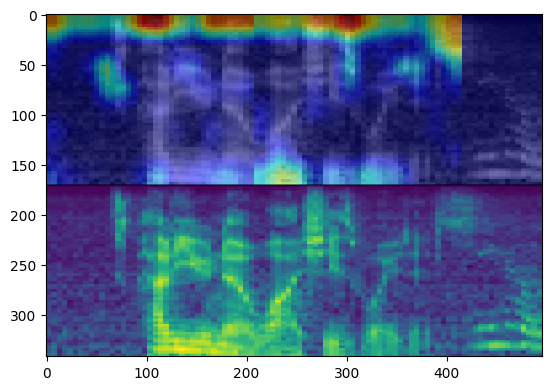

In [9]:
num_frames = 1 + int(np.floor((num_samples - 400) / 160))
log_mel_raw = np.load(f'heatmaps/{audio_name}_mel_raw.npy')
log_mel_overlapping = np.load(f'heatmaps/{audio_name}_mel_overlapping.npy')
log_mel = log_mel_raw + np.abs(np.min(log_mel_raw))
log_mel /= np.max(log_mel)
log_mel*=255
log_mel = cv2.cvtColor(log_mel.astype(np.uint8), cv2.COLOR_GRAY2RGB)/255.

log_mel_heatmap = np.zeros((log_mel.shape[0], log_mel.shape[1]))

log_mel_overlapping = log_mel_overlapping + np.abs(np.min(log_mel_overlapping))
log_mel_overlapping /= np.max(log_mel_overlapping)
log_mel_overlapping*=255
log_mel_overlapping = cv2.cvtColor(log_mel_overlapping.astype(np.uint8), cv2.COLOR_GRAY2RGB)/255.

log_mel_heatmap_overlapping = np.zeros((log_mel_overlapping.shape[0], log_mel_overlapping.shape[1]))
for i in range(len(audio_mel)):
    mel_heatmap = audio_grad_cam[i]
    log_mel_heatmap_overlapping[96*i : i*96+96,:]= log_mel_heatmap_overlapping[96*i : i*96+96,:] + cv2.resize(mel_heatmap, (64,96))

for i in range((num_frames//32-1)):
    offset = 13
    new_shape = log_mel_heatmap[i*offset:i*offset+offset,:].shape
    log_mel_heatmap[i*offset:i*offset+offset,:] = cv2.resize(log_mel_heatmap_overlapping[i*32:i*32+32,:], (new_shape[1], new_shape[0]))

result = show_cam_on_image(log_mel, log_mel_heatmap, use_rgb=True)
plt.imshow(cv2.rotate(result, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.axis('off')
plt.savefig(f'temp_1.png', bbox_inches='tight', pad_inches=0)
plt.close()
plt.imshow(cv2.rotate(log_mel_raw, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.axis('off')
plt.savefig(f'temp_2.png', bbox_inches='tight', pad_inches=0)
plt.close()
temp_1 = cv2.imread("temp_1.png")
border = np.zeros((2, temp_1.shape[1],3)).astype(np.uint8)
temp_2 = cv2.imread("temp_2.png")
output = np.concatenate([temp_1, border, temp_2], axis=0)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
output = cv2.resize(output, (0,0), fx=1.0, fy=0.5)
plt.imshow(output)

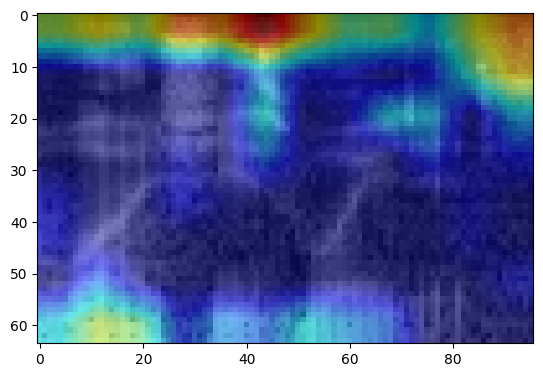

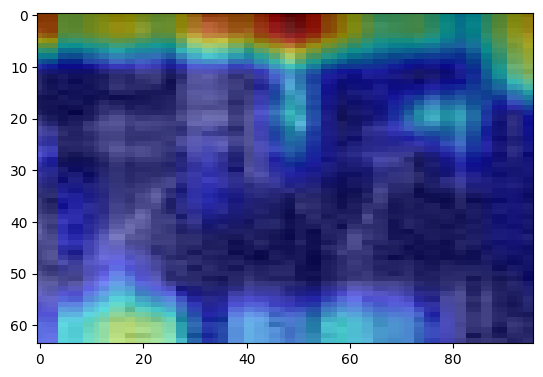

In [10]:
# recheck plot
index = 1
test = audio_mel[index].squeeze().numpy() + np.abs(np.min(audio_mel[index].squeeze().numpy()))
test /= np.max(test)
test*=255 
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB) / 255.

mel = audio_grad_cam[index] + np.abs(np.min(audio_grad_cam[index]))
mel /= np.max(mel)
mel *= 255
mel = cv2.resize(mel, (test.shape[1],test.shape[0]))
mel /= 255
result = show_cam_on_image(test, mel, use_rgb=True)
plt.imshow(cv2.rotate(result, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.show()
observe = cv2.resize(cv2.cvtColor(temp_1[:,200:400,:], cv2.COLOR_BGR2RGB), (result.shape[0], result.shape[1]))
plt.imshow(observe)

In [11]:
bert_attention, text_attention, fusion_attention = network(input_ids.to(device),audio.to(device), output_attentions=True)[1]

In [12]:
from transformers import (
    BertTokenizer
)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encoder_text = tokenizer.convert_ids_to_tokens(input_ids[0])
encoder_text

['[CLS]',
 'how',
 'do',
 'you',
 'know',
 'why',
 'she',
 "'",
 's',
 'waited',
 '?',
 '[SEP]']

In [13]:
# get the mean attention of all head
fusion_attention_mean = fusion_attention.mean(1).squeeze()
text_attention_mean = text_attention.mean(1).squeeze()
fusion_attention_mean.size(), text_attention_mean.size()

(torch.Size([14, 14]), torch.Size([12, 12]))

In [14]:
# only focus on cls token and text token
cls_attention = fusion_attention_mean[0,:text_attention_mean.shape[0]]
cls_attention.size(), cls_attention

(torch.Size([12]),
 tensor([0.0557, 0.0584, 0.0593, 0.0604, 0.0612, 0.0610, 0.0596, 0.0602, 0.0612,
         0.0598, 0.0598, 0.0600], grad_fn=<SliceBackward0>))

In [15]:
token_weight= torch.log(cls_attention)
token_weight

tensor([-2.8883, -2.8409, -2.8245, -2.8061, -2.7937, -2.7973, -2.8208, -2.8106,
        -2.7943, -2.8159, -2.8169, -2.8136], grad_fn=<LogBackward0>)

In [16]:
token_weight = token_weight + (-torch.min(token_weight))
token_weight

tensor([0.0000, 0.0474, 0.0638, 0.0822, 0.0946, 0.0910, 0.0675, 0.0777, 0.0940,
        0.0724, 0.0714, 0.0747], grad_fn=<AddBackward0>)

In [17]:
token_weight = token_weight/torch.max(token_weight) 
token_weight = token_weight.detach().cpu().numpy() * 255
token_weight

array([  0.     , 127.84368, 171.99382, 221.37187, 255.     , 245.21355,
       181.84964, 209.23036, 253.38754, 194.98817, 192.50462, 201.34222],
      dtype=float32)

In [18]:
with open(f'heatmaps/{audio_name}.ass', 'r') as f:
    subs_data = f.readlines()

subs = []
for line in subs_data:
    if line.startswith('Dialogue'):
        data = line.split(',')
        start = float(data[1].split(':')[-1])
        end = float(data[2].split(':')[-1])
        text = data[-1].strip()
        subs.append((start, end, text))

2.3499375
(684, 992, 3)


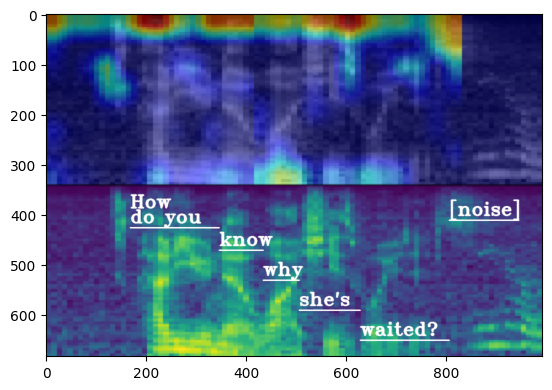

In [19]:
import sounddevice as sd
import soundfile as sf
import speech_recognition
r = speech_recognition.Recognizer() 
wav_data, sr = sf.read(audio_path, dtype="int16")
duration = len(wav_data) / float(sr)
print(duration)
output_with_text = cv2.resize(output.copy(), (0,0), fx=2, fy=2)
index = 0
# font 
font = cv2.FONT_HERSHEY_TRIPLEX
for i, sub in enumerate(subs):
    start, end, text = sub
    start = int(start*output_with_text.shape[1]/ duration)
    end = int(end*output_with_text.shape[1]/ duration)
    
      
    # org 
    org = (start, 60*index + output_with_text.shape[0]//2+60) 
    # org = (start, 60*index + output_with_text.shape[0]//2+35) 
      
    # fontScale 
    fontScale = 1.2
    # fontScale=0.7
       
    # Blue color in BGR 
    color = (255, 255, 255) 
      
    # Line thickness of 2 px 
    thickness = 2
    # thickness=1
    if len(text) >= 8:
        sub_text_1 = " ".join(text.split()[:1])
        sub_text_2 = " ".join(text.split()[1:])
        output_with_text = cv2.putText(output_with_text, sub_text_1, (org[0],org[1]-15), font,  
                       fontScale, color, thickness, cv2.LINE_AA)
        output_with_text = cv2.putText(output_with_text, sub_text_2, (org[0],org[1]+15), font,  
                       fontScale, color, thickness, cv2.LINE_AA)
        if len(sub_text_2) == 0:
            output_with_text = cv2.line(output_with_text, (start,org[1]-15 +10), (end,org[1]-15+10), color, thickness)
        else:
            output_with_text = cv2.line(output_with_text, (start,org[1]+15 +10), (end,org[1]+15+10), color, thickness) 
    else:
        output_with_text = cv2.putText(output_with_text, text, org , font,  
                       fontScale, color, thickness, cv2.LINE_AA) 
        output_with_text = cv2.line(output_with_text, (start, org[1] + 10), (end, org[1]+10), color, thickness) 
    # index+=2
    index+=1
    if 60*index + output_with_text.shape[0]//2 + 10 > output_with_text.shape[0]- 35:
        index=0
# output_with_text = cv2.resize(output_with_text, (0,0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# (2000,1100)# happy, sad
# (800,1200)# neutral, anger
output_with_text = cv2.resize(output_with_text, (992,684), interpolation=cv2.INTER_CUBIC)
plt.imshow(output_with_text)
print(output_with_text.shape)

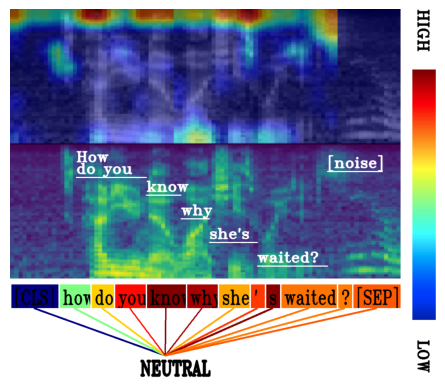

In [20]:
LABEL_MAP = [
    "ANGER",
    "HAPPY",
    "SAD",
    "NEUTRAL"]

ret = np.zeros((60, 0,3)).astype(np.uint8)
ret_index = 0
encoder_text_location = []
for i in range(token_weight.shape[0]):
    text_weight = np.ones((60, 10 + 30 * len(encoder_text[i]) + 10)) * token_weight[i].item()
    text_weight = cv2.applyColorMap(text_weight.astype(np.uint8) ,cv2.COLORMAP_JET)
    text_weight = cv2.putText(text_weight, encoder_text[i], (10,50), font,  
                       1.7, (0,0,0), 2, cv2.LINE_AA)
    border = np.ones_like(text_weight)[:,:5]*255
    ret = np.concatenate([ret,border, text_weight], axis=1)
    encoder_text_location.append(((ret.shape[1] - ret_index) // 2 + ret_index,60))
    ret_index = ret.shape[1]

# add cls token
border = np.ones((120,ret.shape[1],3),dtype=np.uint8)*255
cls_ret = np.ones_like(ret)*255

cls_token_name = LABEL_MAP[emo]
cls_ret = cv2.putText(cls_ret, cls_token_name, (cls_ret.shape[1]//3,50), font,  
                       1.7, (0,0,0), 5, cv2.LINE_AA)
cls_ret = cv2.putText(cls_ret, cls_token_name, (cls_ret.shape[1]//3,50), font,  
                       1.7, (0,0,0), 5, cv2.LINE_AA)

ret = np.concatenate([ret,border, cls_ret], axis=0)

for i in range(token_weight.shape[0]):
    start_point = encoder_text_location[i] 
    end_point = (cls_ret.shape[1]//3 + 30 * (len(cls_token_name)//2), 60*3) 
    # Green color in BGR 
    text_weight = np.ones((60, 10 + 30 * len(encoder_text[i]) + 10)) * token_weight[i].item()
    text_weight = cv2.applyColorMap(text_weight.astype(np.uint8) ,cv2.COLORMAP_JET)
    color = [int(_) for _ in text_weight[0,0]]
    # Line thickness of 9 px 
    thickness = 3
    # Using cv2.line() method 
    # Draw a diagonal green line with thickness of 9 px 
    ret = cv2.line(ret, start_point, end_point, color, thickness) 

ret = cv2.cvtColor(ret,cv2.COLOR_BGR2RGB)
ret = cv2.resize(ret, (output_with_text.shape[1], ret.shape[0]))
border = np.ones((15, output_with_text.shape[1],3)).astype(np.uint8) * 255
output_with_text_and_attention = np.concatenate([output_with_text, border,  ret], axis=0)


jet_color = cv2.imread("heatmaps/COLORMAP_JET.png")[:-20,:-20,:]

jet_color = cv2.cvtColor(jet_color, cv2.COLOR_BGR2RGB)
jet_color = cv2.rotate(jet_color, cv2.ROTATE_90_CLOCKWISE)
jet_color = cv2.resize(jet_color, (60,output_with_text_and_attention.shape[0]-300))
high = np.ones((60, 150, 3), dtype=np.uint8)*255
cv2.putText(high, "HIGH", (0,45), font,  
                        1.3, (0,0,0), 2, cv2.LINE_AA)
high = cv2.rotate(high, cv2.ROTATE_90_CLOCKWISE)
low = np.ones((60, 150, 3), dtype=np.uint8)*255
cv2.putText(low, "LOW", (50,45), font,  
                        1.3, (0,0,0), 2, cv2.LINE_AA)
low = cv2.rotate(low, cv2.ROTATE_90_CLOCKWISE)
jet_color = np.concatenate([high,jet_color, low ],axis=0)
border = np.ones_like(jet_color)[:,:30]*255
output_with_text_and_attention = np.concatenate([output_with_text_and_attention,border,jet_color],axis=1)
plt.imshow(output_with_text_and_attention)
plt.axis('off')
plt.savefig(os.path.basename(audio_path)[:-4]+"_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()